<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Ponto de partida (EDA) </h1> 
</div>

![](img/header.png?t=2021-04-09-00-57-05)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de uma competição da Flai - da compreensão do conjunto de dados até a preparação para serem usados em um modelo machine learning, vamos passar pelas seguintes etapas:

- Leitura no conjunto de dados;
- Calculando estatísticas sobre o conjunto de dados;
- Visualização univariada;
- Visualizando multivariada;
- Pré-processamento;
- Modelagem.

<font color=green> <b>Definição do Problema</b> </font>

Objetivo da Competição é <b>prever o resultado de vendadas de televendas</b>, a métrica de avaliação é <b> F1-score</b>.

<p style="border-bottom: 2px solid #256B5D"/>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q colorama
    !pip install --q tensorflow
    !pip install --q wandb
    !pip install --q eli5
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import shap
import multiprocessing
import glob
import scipy.optimize 
import scipy.special

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import scipy.stats       as stats
import statsmodels.api   as sm

In [4]:
from matplotlib.axes._axes   import _log as matplotlib_axes_logger
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer 
from sklearn.preprocessing   import PowerTransformer, Normalizer
from sklearn.preprocessing   import LabelBinarizer, OneHotEncoder, OrdinalEncoder
from sklearn                 import metrics

In [5]:
from datetime                import datetime
from scipy.stats             import skew, norm

***

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [6]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
    
    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = -1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = -1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = -1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = -1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
                    
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [7]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

---

## 1.4. Dataset

### 1.4.1. Descrição de dados

Para este desafio, temos o seguinte conjunto de dados com as seguintes variáveis: 
- idade
- trabalho
- estado civil
- educação
- atraso
- casa
- empréstimo
- contato
- mês
- dia
- duração
- ncontatos
- anterior
- produto
       
### 1.4.2. Arquivos
- <b>treino.csv</b>: conjunto de treinamento;
- <b>teste.csv</b>: conjunto de teste, a tarefa é prever um o valor de aluguél. 

### 1.4.3. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [8]:
path        = '/content/drive/MyDrive/Flai/10/' if COLAB else ''   
path_data   = 'Data/'  
target      = 'produto'
path_automl = 'automl/'

utility.create_fold(path)

### 1.4.4. Carrega dados

In [9]:
df1_train     = pd.read_csv(path + path_data + 'treino.csv')
df1_test      = pd.read_csv(path + path_data + 'teste.csv')
df_submission = pd.DataFrame({target: np.zeros(df1_test.shape[0])})
df1_train.shape, df1_test.shape, df_submission.shape

((5700, 14), (3300, 13), (3300, 1))

In [10]:
df1_train.head()

,idade,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,produto
0,36,escritório,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,1,nenhum,não
1,32,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,4,nenhum,não
2,49,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,1,nenhum,não
3,28,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,1,nenhum,não
4,31,escritório,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,1,apenas um,sim


In [11]:
df1_test.head()

,idade,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior
0,33,trabalhador manual,casado(a),ensino médio,NaN,sim,não,telefone fixo,maio,sexta-feira,curta,1,nenhum
1,41,escritório,casado(a),graduação,NaN,sim,não,telefone fixo,maio,segunda-feira,média,1,nenhum
2,42,terceirizados,solteiro(a),ensino médio,NaN,sim,não,telefone móvel,novembro,quinta-feira,longa,1,nenhum
3,34,empreendedor,casado(a),básico,NaN,sim,sim,telefone fixo,novembro,segunda-feira,média,1,nenhum
4,34,trabalhador manual,casado(a),básico,não,sim,não,telefone móvel,julho,quinta-feira,curta,14,nenhum


<p style="border-bottom: 2px solid #256B5D"/>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Análise Exploratória de Dados (EDA) </h1>    
</div>

Antes de trabalhar com qualquer tipo de dados é importante entendê-los. Um passo crucial para esse objetivo é a Análise Exploratória de Dados (EDA): uma combinação de visualizações e análise estatística (uni, bi e multivariada) que nos ajuda a entender melhor os dados com os quais estamos trabalhando e obter insights sobre seus relacionamentos.<p>
    Então, vamos explorar nossa variável de destino e como as outras variáveis a influenciam.

In [12]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

## 2.1. Dimensão do DataSet

In [13]:
print('TREINO')
print('Number of Rows: {}'.format(df2_train.shape[0]))
print('Number of Columns: {}'.format(df2_train.shape[1]), end='\n\n')

print('TESTE')
print('Number of Rows: {}'.format(df2_test.shape[0]))
print('Number of Columns: {}'.format(df2_test.shape[1]))

TREINO
Number of Rows: 5700
Number of Columns: 14

TESTE
Number of Rows: 3300
Number of Columns: 13


---

## 2.2. Tipo de dados

In [14]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5700 entries, 0 to 5699
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idade         5700 non-null   int64 
 1   trabalho      5477 non-null   object
 2   estado civil  5687 non-null   object
 3   educação      5457 non-null   object
 4   atraso        4677 non-null   object
 5   casa          5562 non-null   object
 6   empréstimo    5562 non-null   object
 7   contato       5700 non-null   object
 8   mês           5700 non-null   object
 9   dia           5700 non-null   object
 10  duração       5700 non-null   object
 11  ncontatos     5700 non-null   int64 
 12  anterior      5700 non-null   object
 13  produto       5700 non-null   object
dtypes: int64(2), object(12)
memory usage: 623.6+ KB


In [15]:
df2_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idade         3300 non-null   int64 
 1   trabalho      3183 non-null   object
 2   estado civil  3295 non-null   object
 3   educação      3157 non-null   object
 4   atraso        2711 non-null   object
 5   casa          3218 non-null   object
 6   empréstimo    3218 non-null   object
 7   contato       3300 non-null   object
 8   mês           3300 non-null   object
 9   dia           3300 non-null   object
 10  duração       3300 non-null   object
 11  ncontatos     3300 non-null   int64 
 12  anterior      3300 non-null   object
dtypes: int64(2), object(11)
memory usage: 335.3+ KB


In [16]:
print(f'{3*"="} For Pandas {10*"="}\n{(df2_train.dtypes).value_counts()}')
print(f'\n{3*"="} For Datatable {7*"="}\n{(df2_test.dtypes).value_counts()}')

=== For Pandas ==========
object    12
int64      2
dtype: int64

=== For Datatable =======
object    11
int64      2
dtype: int64


---

## 2.3. Identificar NA

In [17]:
missing = utility.missing_zero_values_table(df2_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 14 colunas e 5700 linhas. 
Existem 6 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados
0,atraso,1023,17.950000,object
1,educação,243,4.260000,object
2,trabalho,223,3.910000,object
3,casa,138,2.420000,object
4,empréstimo,138,2.420000,object
5,estado civil,13,0.230000,object


In [18]:
missing = utility.missing_zero_values_table(df2_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 13 colunas e 3300 linhas. 
Existem 6 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados
0,atraso,589,17.850000,object
1,educação,143,4.330000,object
2,trabalho,117,3.550000,object
3,casa,82,2.480000,object
4,empréstimo,82,2.480000,object
5,estado civil,5,0.150000,object


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Observamos que temos 6 variáveis com valores ausentes, para o modelo de linha de base vamos utilizar a moda para os valores ausentes. 
    
    
</div>

## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

In [19]:
feature_float = df2_test.select_dtypes(np.number).columns.to_list()
feature_cat   = df2_test.select_dtypes(object).columns.to_list()

msg = 'Temos {} variávies numéricas e {} categóricas.'
print(msg.format(len(feature_float), len(feature_cat)))

Temos 2 variávies numéricas e 11 categóricas.


- Train

In [20]:
df2_train.describe().style.background_gradient(cmap='YlOrRd')

,idade,ncontatos
count,5700.000000,5700.000000
mean,40.976842,2.457719
std,11.217724,2.585706
min,19.000000,1.000000
25%,33.000000,1.000000
50%,38.000000,2.000000
75%,48.000000,3.000000
max,99.000000,42.000000


In [21]:
df2_test.describe().style.background_gradient(cmap='YlOrRd')

,idade,ncontatos
count,3300.000000,3300.000000
mean,41.496364,2.486667
std,11.365873,2.700489
min,18.000000,1.000000
25%,33.000000,1.000000
50%,39.000000,2.000000
75%,49.000000,3.000000
max,89.000000,35.000000


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Alguns pontos que podemos destacar: 
- A variável idade parece ter com alguma relevância, pois tem um desvio padrão relativamente alto, isso é bom para a separação das classes ajuda os modelos a identificar padrões;
    
- Outro ponto em relação a idede é valor máximo em ambos datasets em relação as outras medidas estatísticas, indicando a presença de outlier, o qual devemos fazer uma análise mais aprofundada, caso necessário podemos fazer a remoção ou utilizar alguma técnica que indique para os modelos que a amostra tem valor discrepante; 

- A variável ncontatos ter relevância com um desvio padrão muito alto, o valor máximo é muito alto em relação as outras medidas, pode ser um valor digitado errado.   
    
</div>

---

## 2.6. Distribuição

### 2.6.1. Train / Test

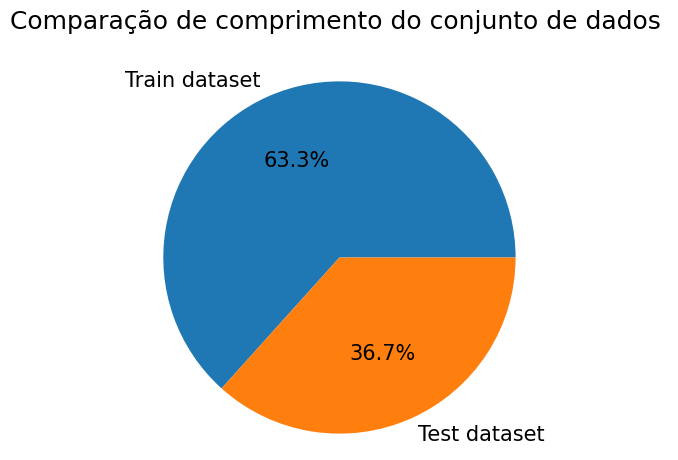

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df2_train), len(df2_test)],
             labels   = ["Train dataset", "Test dataset"],
             #colors   = ["teal", "b"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

---

### 2.6.2. Distribuição Train x Test

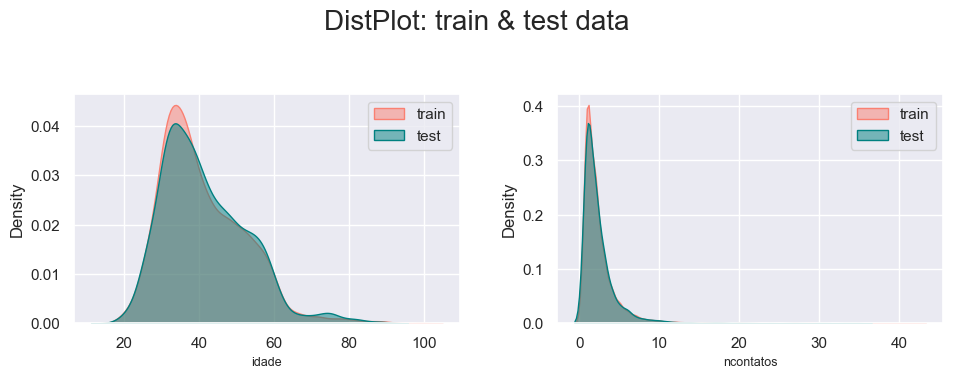

In [30]:
features = df2_test.select_dtypes(np.number).columns

L    = len(features)
nrow = int(np.ceil(L/3))
ncol = 2

remove_last= (nrow * ncol) - L
sns.set(style="darkgrid")

fig, ax = plt.subplots(nrow, ncol,figsize=(10 ,4))
fig.subplots_adjust(top=0.95)
i = 1

for feature in features:    
    plt.subplot(nrow, ncol, i)    
    ax = sns.kdeplot(df2_train[feature], shade=True, color='salmon',  alpha=0.5, label='train')
    ax = sns.kdeplot(df2_test[feature], shade=True, color='teal',  alpha=0.5, label='test')
    plt.xlabel(feature, fontsize=9)
    plt.legend()    
    i += 1
    
plt.suptitle('DistPlot: train & test data', fontsize=20)
fig.tight_layout(pad=2.0);

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Observando os gráficos acima, que as variáveis seguem a mesma distribuição em ambos os datasets, podemos destacar os seguintes pontos: 
    
Vamos dar uma olhada na distribuição dessas variáveis em relação das categóricas.     
</div>

In [33]:
sns.set(style="darkgrid")

for col in feature_cat: 
    
    features = df2_test.select_dtypes(np.number).columns

    L    = len(features)
    nrow = int(np.ceil(L/3))
    ncol = 2

    remove_last= (nrow * ncol) - L
    

    
    print(col)
    for col_classe in df2_train[col].unique(): 
        print(col_classe)
        
    print()
    
    #_ = df1_train[df1_train['trabalho'] == 'escritório']
    

trabalho
escritório
trabalhador manual
especialista
do lar
empreendedor
terceirizados
aposentado
gerência
desempregado
nan

estado civil
casado(a)
solteiro(a)
divorciado(a)
nan

educação
ensino médio
básico
nan
ensino técnico
graduação

atraso
não
nan

casa
não
sim
nan

empréstimo
não
nan
sim

contato
telefone fixo
telefone móvel

mês
junho
julho
maio
outubro
novembro
agosto
março
abril
dezembro
setembro

dia
quinta-feira
terça-feira
segunda-feira
sexta-feira
quarta-feira

duração
média
longa
curta

anterior
nenhum
apenas um
mais de um



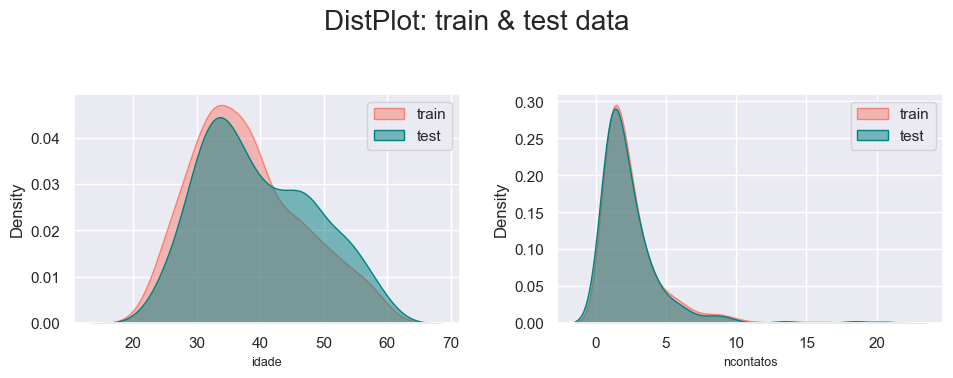

In [49]:
features = df1_test.select_dtypes(np.number).columns

L    = len(features)
nrow = int(np.ceil(L/3))
ncol = 2

remove_last= (nrow * ncol) - L
sns.set(style="darkgrid")

fig, ax = plt.subplots(nrow, ncol,figsize=(10 ,4))
fig.subplots_adjust(top=0.95)
i = 1

_tr = df1_train[df1_train['trabalho']=='terceirizados']
_ts = df1_test[df1_test['trabalho']=='terceirizados']

for feature in features:    
    plt.subplot(nrow, ncol, i)    
    ax = sns.kdeplot(_tr[feature], shade=True, color='salmon',  alpha=0.5, label='train')
    ax = sns.kdeplot(_ts[feature], shade=True, color='teal',  alpha=0.5, label='test')
    plt.xlabel(feature, fontsize=9)
    plt.legend()    
    i += 1
    
plt.suptitle('DistPlot: train & test data', fontsize=20)
fig.tight_layout(pad=2.0);

---

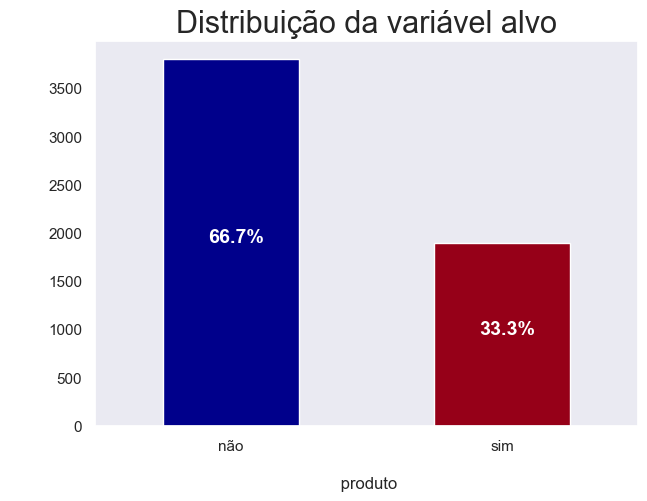

In [50]:
plt.figure(figsize=(7,5))  
_ = df2_train.groupby([target])[target].count()
utility.graf_bar(_,icecream,'Distribuição da variável alvo',target, '');

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Os dados estão desbalanceados, precisamos utilizar alguma técnica de balanceamento de dados como: <b>oversampling ou undersampling</b>. 
   
</div>

---

### 2.6.3. Proporção de variáveis

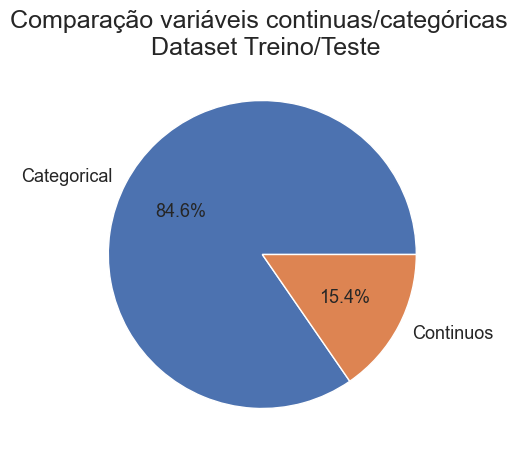

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.pie([ len(feature_cat), len(feature_float)], 
        labels=['Categorical', 'Continuos' ],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')

#ax.axis("equal")
ax.set_title("Comparação variáveis continuas/categóricas \n Dataset Treino/Teste", fontsize=18)
fig.set_facecolor('white')
plt.show()

## 2.7. Dados Qualitativos

Vamos fazer uma contagem das observações e em cada variável categórica, para termos uma noção de como nosso conjunto de dados estar distribuído.

In [52]:
for i in feature_cat:
    print("Coluna: ",i)
    print('-'*30)
    print('TREINO:',  df2_train[[i]].value_counts(), '\n') 
    print('TESTE :',  df2_test[[i]].value_counts(), "\n")

Coluna:  trabalho
------------------------------
TREINO: trabalho          
escritório            1530
trabalhador manual    1174
especialista           905
terceirizados          509
gerência               421
empreendedor           356
aposentado             281
desempregado           156
do lar                 145
dtype: int64 

TESTE : trabalho          
escritório            880
trabalhador manual    677
especialista          533
terceirizados         295
gerência              227
empreendedor          201
aposentado            195
desempregado           91
do lar                 84
dtype: int64 

Coluna:  estado civil
------------------------------
TREINO: estado civil 
casado(a)        3315
solteiro(a)      1760
divorciado(a)     612
dtype: int64 

TESTE : estado civil 
casado(a)        1983
solteiro(a)       966
divorciado(a)     346
dtype: int64 

Coluna:  educação
------------------------------
TREINO: educação      
graduação         1790
básico            1679
ensino médio 

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
- A variável <b>atraso</b> tem apenas uma categorial em ambos dataset, podemos fazer a exclusão dessa variável. 
    
Vamos dar uma olhada na correlação das variaveis categóricas, criamos uma função que calcula a matriz de coeficientes de Cramer, que permite entender a correlação entre duas variáveis categóricas em um conjunto de dados.
    
</div>

### 2.7.1. Correlação
Primeira coisa que vamos fazer é criar um novo dataset e transformar a variável <b>hora</b> em categórica, assim vamos ter uma ideia da magnetute da variável como categórica. 

In [55]:
def cromer_v( x, y):
    cm       = pd.crosstab(x, y).to_numpy()        
    n        = cm.sum()
    r, k     = cm.shape
    chi2     = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
    kcorr    = k - (k-1) **2/(n-1)
    rcorr    = r - (r-1) **2/(n-1)    
    v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
    return v  

In [56]:
def generate_category_table(data):

    cols    = data.select_dtypes(include='object').columns
    dataset = pd.DataFrame()

    for i in cols:
        corr = []
        for x in cols: 
            corr.append(cromer_v(data[i],data[x]))

        aux     = pd.DataFrame({i:corr})
        dataset = pd.concat([dataset, aux], axis=1) 

    return dataset.set_index(dataset.columns)


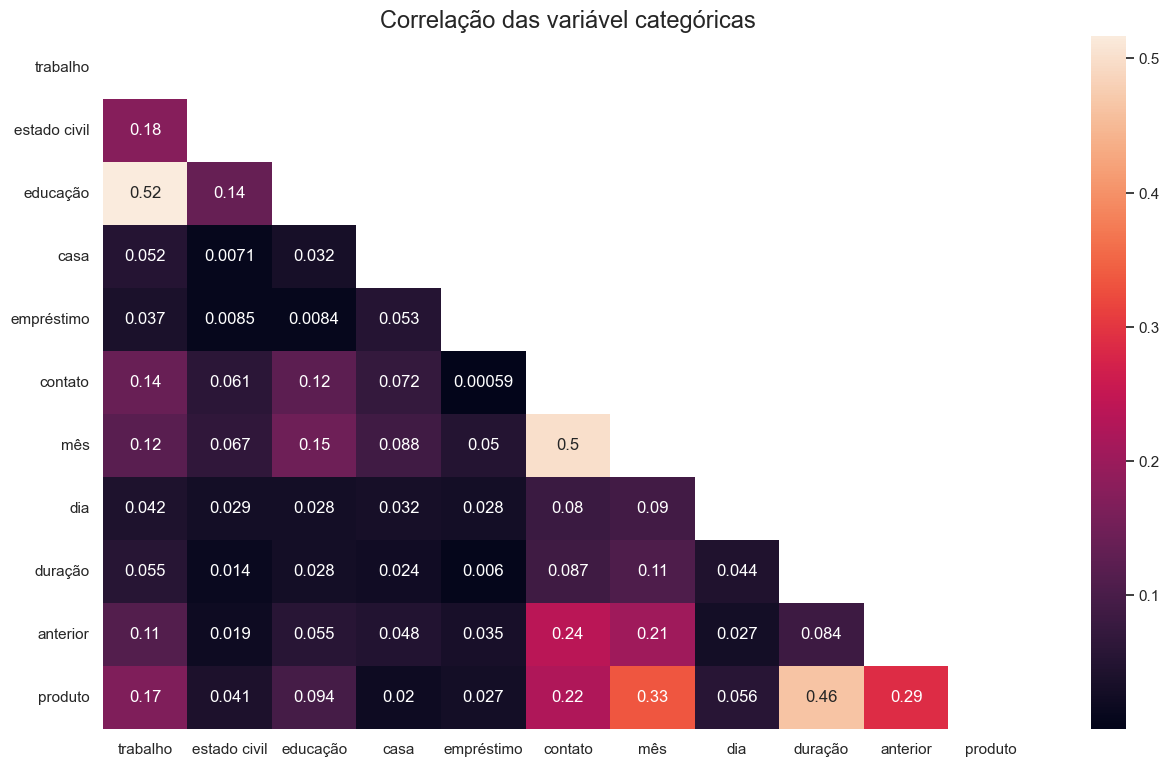

In [54]:
df_cat         = df2_train.copy().dropna()
f_cat          = feature_cat.copy()
f_cat.remove('atraso')

sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(15,9))

df         = df_cat[f_cat]
df[target] = df_cat[target].astype(object)

corr = generate_category_table(df)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot=True, mask= mask). \
         set_title('Correlação das variável categóricas', fontsize=17);

del df

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Temos uma correlação baixa entre as variáveis categóricas, uma razoavel correlação em relação a variável alvo, a variável <b>duração</b> tem a maior correlção com a variável alvo, é um indicativo que essa variável será significativa para a modelagem.  <br>
    

    
Vamos fazer uma análise de cada variável.

</div>

### 2.7.2. Análise univarianda

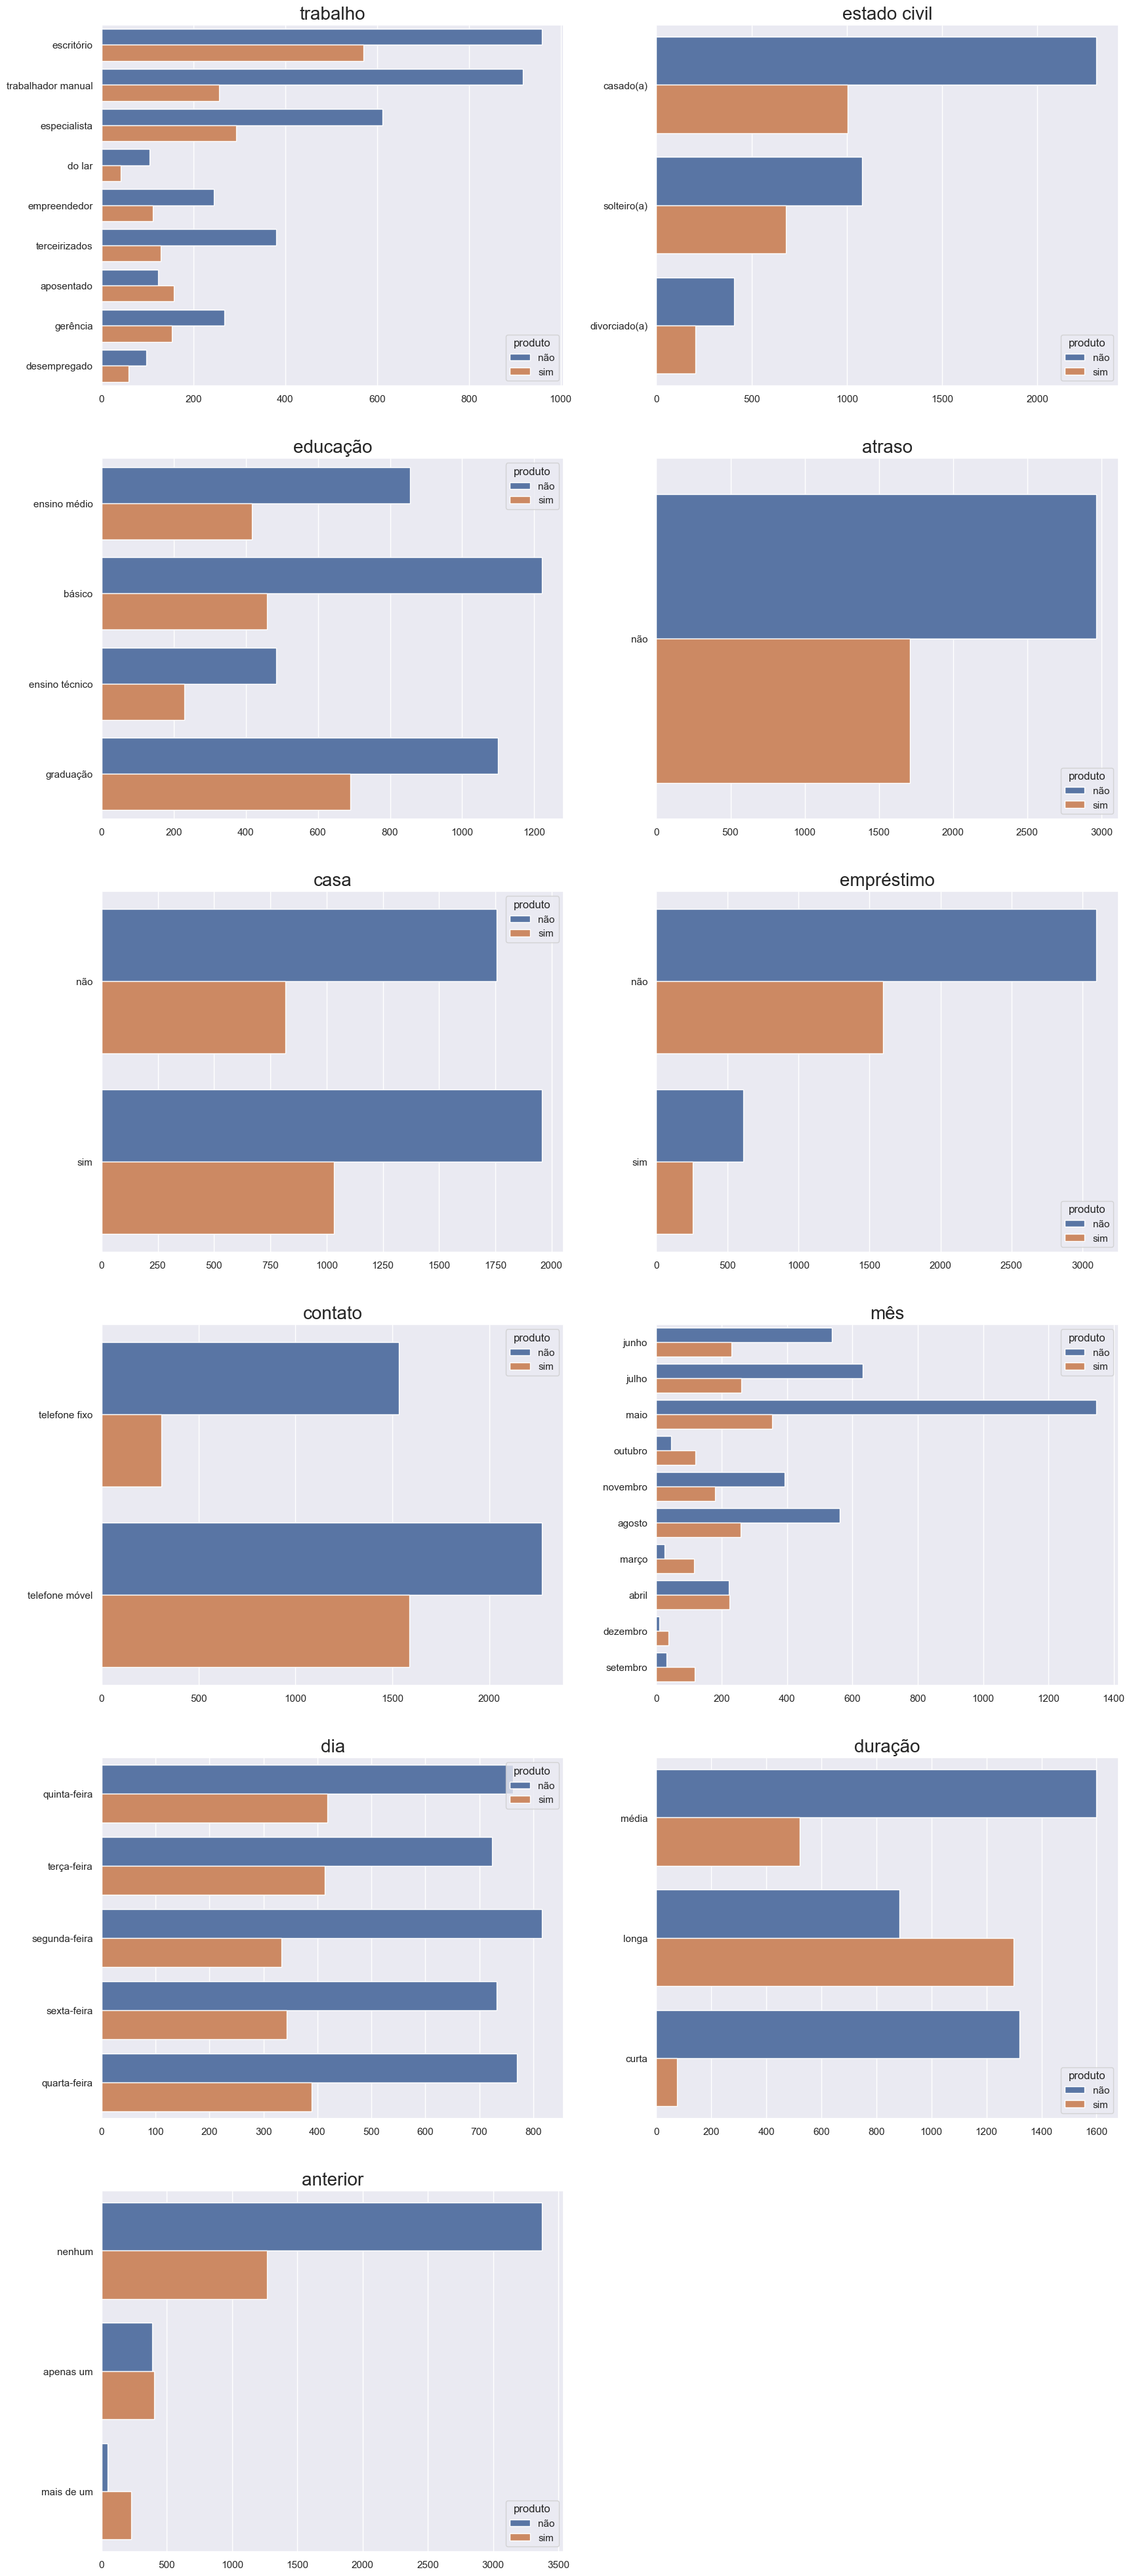

In [65]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,50))

row = int(len(feature_cat)/2)+1

for i, col in enumerate(feature_cat):    
    plt.subplot(row, 2, i+1)
    sns.countplot(data=df2_train, y=col, hue=target, orient='v')
    plt.title(col,  fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    ;    
    
fig.tight_layout(pad=3.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

- No domingo o aluguél de baixo em relação ao outros dias;
- Quando temos feriado, o valor de aluguél é menor e visualmente é significativo; 
- No verão temos aumento de aluguéis e no inverno uma baixa segnificativa; 
- No intervalor das 10h até as 18h temos um aumento no aluguél de bicicleta, com uma baixa as 19h até as 4h da manhã, um ponto a destacar é no horário das 8h, que tem uma alta significante em relação aos outros horário, provavelmente a explicação para isso é o horário de trabalho ou atividade fisíca.  <p>
    
Vamos fazer uma análise mais detalhada, com o cruzamento dessas variáveis.

</div>

### 2.7.3. Análise bivariada

TypeError: Neither the `x` nor `y` variable appears to be numeric.

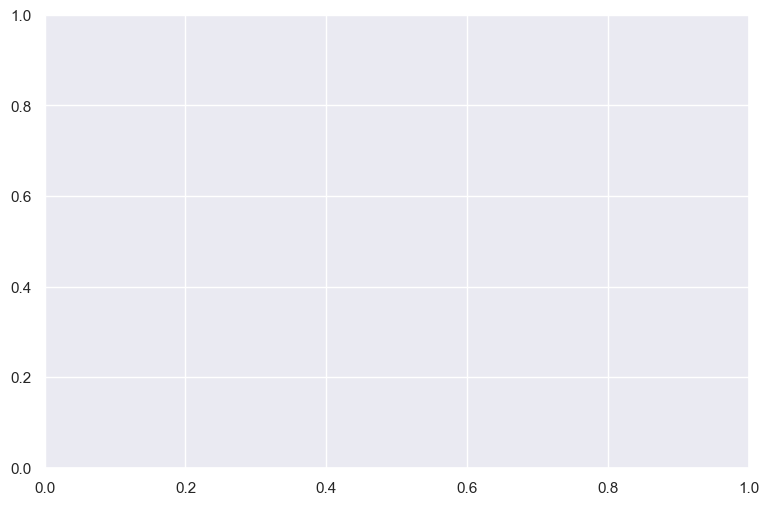

In [118]:
i=1
sns.set(style="darkgrid")
plt.figure(figsize=(20,20))
for col1 in (feature_cat):
    for x, col2 in enumerate(feature_cat):
        if col1!=col2:            
            plt.subplot(3,2, i)    
            sns.barplot(data=df2_train, x=col1, y=target, hue=col2, estimator=np.mean);            
            plt.title('{} x {}'.format(col1, col2), fontsize=20)
            plt.xlabel('')
            i+=1

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

- No sabado quando temos feriado aumenta a quantidade de aluguél, porém não parece ser muito significativo o feriado neste dia, porém domingo, segunda e quinta temos uma baixa significativa quando é feriado, a criação de uma variável indicando final de semana e quinta pode ser signifincativa para ajudar a identificar padrões; <p>

- No inverno temos um baixa nos aluguéis, no verão temos um aumento no número de aluguéis, seguido da primavera, aqui demos um ponto importante que devemos destacar, modelagem para estação do ano pode ser um diferencial, pois podemos identificar diferenças significante visualmente.
    
Vamos dar uma olhada na variável <b>hora</b> em relação as variaveis categoricas.     
</div>

ValueError: Could not interpret input 'hora'

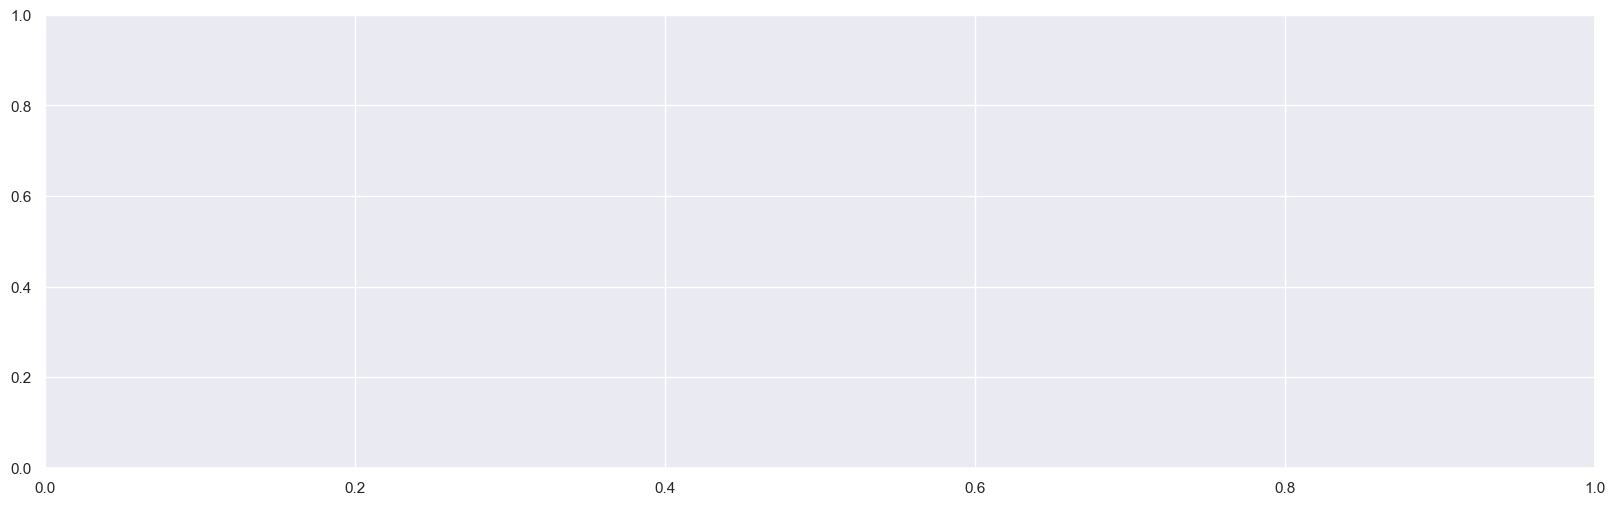

In [119]:
i=1
plt.figure(figsize=(20,20))

for x, col in enumerate(['estação', 'feriado', 'dia']):                
    plt.subplot(3,1, i)    
    sns.barplot(data=df2_train, x='hora', y=target, hue=col, estimator=np.mean);            
    plt.title('{} x {}'.format('hora', col), fontsize=20)
    plt.xlabel('')
    i+=1

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

- No primeiro gráfico observamos no inverno nos horarários das 8h e 18h um aumento no valor do aluguél; 
 
- No segundo gráfico dois pontos que me chamou a atenção: as 8h e 14h temos um aumento no aluguél, um quando não é feriado e outro quando é feriado; 

- Vamos refazer o terceiro gráfico. 

    
</div>

ValueError: Could not interpret input 'hora'

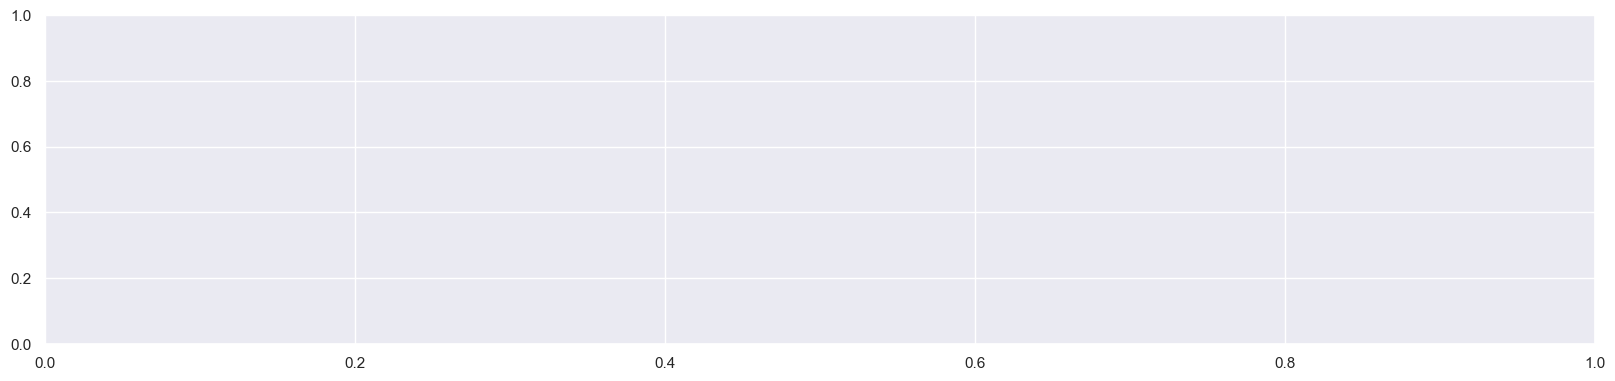

In [120]:
i=1
plt.figure(figsize=(20,35))

for col_unique in df2_train['dia'].unique():
    filtro = df2_train['dia'] == col_unique
    plt.subplot(7,1, i)    
    sns.barplot(data=df2_train[filtro], x='hora', y=target, estimator=np.mean);            
    plt.title('{}'.format(col_unique), fontsize=20)
    plt.xlabel('')
    i+=1    
    fig.tight_layout(pad=3.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Podemos observar nos gráficos acima, algumas fases do dia: <b>manhã, tarde, noite e madrugada</b>, podemos criar uma variárial que indique essas fases do dia. 
    
</div>

## 2.8. Dados Quantitativos

### 2.8.1. Correlação
Vamos examinar a correlação entre as variáveis.

In [66]:
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(10,7))

Utility.graf_feature_corr(df_         = df2_train.copy(), 
                        annot_      = True, 
                        threshold_  = .7, 
                        print_var_  = True, 
                        print_graf_ = True, 
                        mask_       = True);

TypeError: graf_feature_corr() missing 1 required positional argument: 'self'

<Figure size 1000x700 with 0 Axes>

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
- Como podemos observar, a correlação fica entre -0.6 e 0.5%, sendo assim, não temos variáveis autocorrelacionadas, mais a frente com a criação de novas variáveis podemos ter variáveis autocorrelacionadas e voltaremos a fazer essa análise de autocorrelação. <p>
    
- Temos duas variáveis que tem correlação negativa com a variável alvo, são elas: <b>chuva</b> e <b>umidade</b>; <p>
    
- As variáveis <b>temperatua</b> e <b>hora</b> são as variávies que tem maior correlação com a variável alvo, consequentemente são as variáveis mais importantes para explicar o aluguél; <p>
    
- Fazendo um comparação da variável hora como númerica e quando ela foi transformada em categórica, que tem uma correlação maior. 

    
</div>

### 2.8.3. Relação linear

In [122]:
sns.set(style="darkgrid")

TypeError: can't multiply sequence by non-int of type 'float'

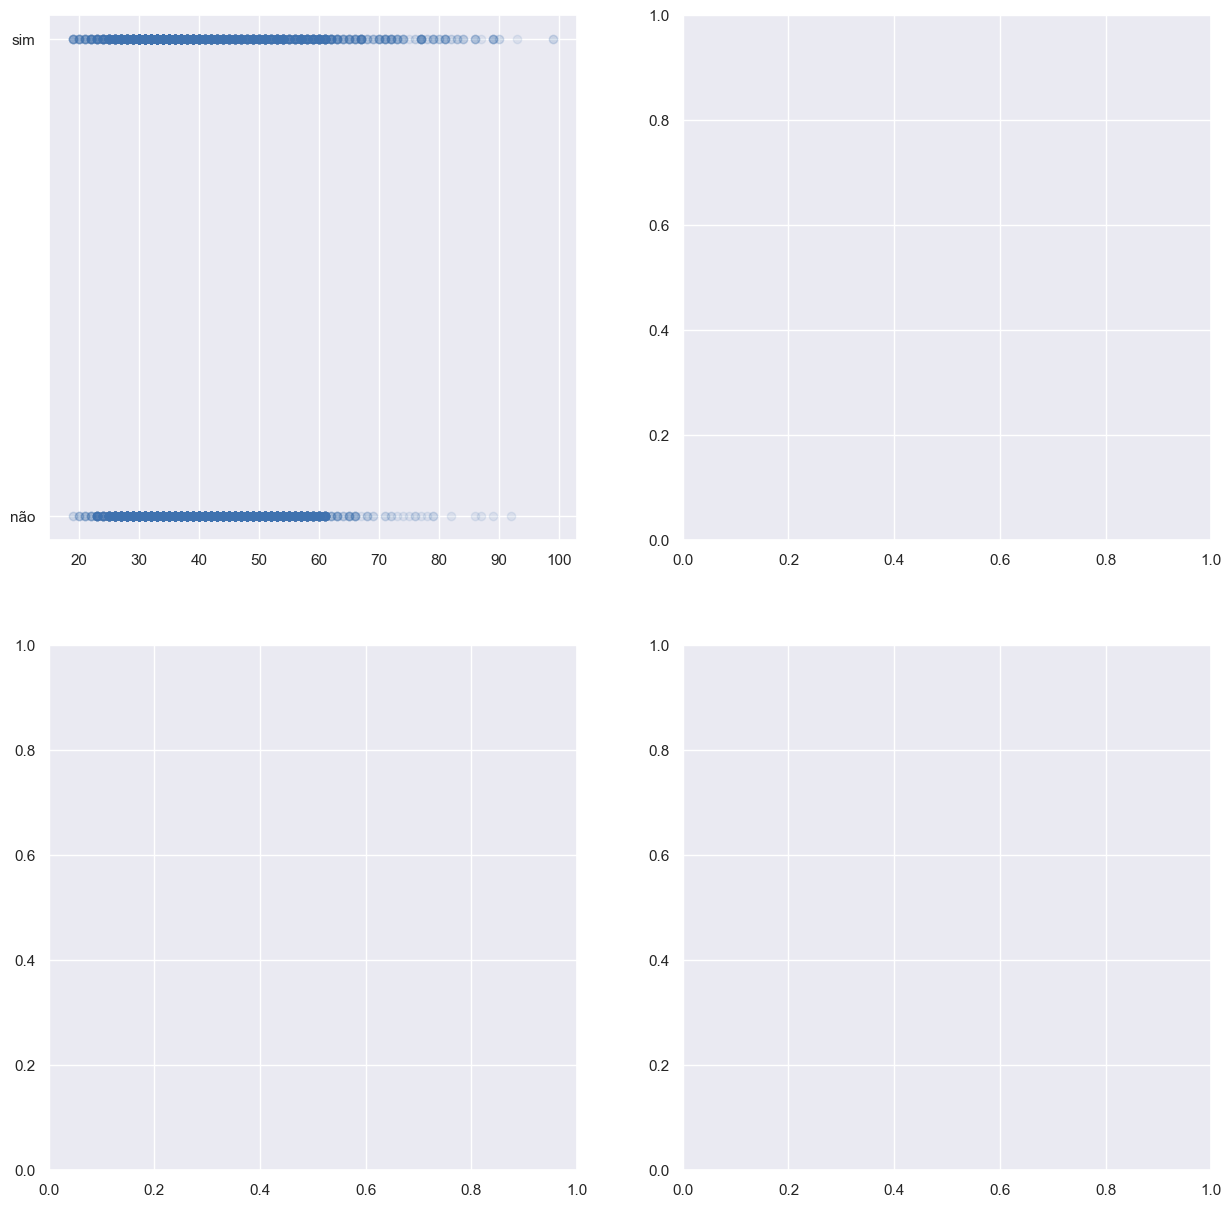

In [123]:
row    = int(len(feature_float)/2+1) 
fig,ax = plt.subplots(row,2,figsize=(15,15))
l      = 0 
c      = 0 

for i, col in enumerate(feature_float):
    sns.regplot(data        = df2_train, 
                x           = col, 
                y           = target,  
                scatter_kws = {'alpha':0.1}, 
                ax          = ax[l][c], 
                color       = '#3f72af')
    
    c  = 1 if c==0 else 0    
    l += 1 if i%2==1 else 0
    
plt.suptitle('\n Análise de Correlação do Aluguél', fontsize=20)
fig.tight_layout(pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

- No primeiro gráfico, observamos um crescimento do aluguél principlamente entre as 10h até as 18h, temos uma correlação positiva, com essa pequena análise podemos organizar nosso fluxo de trabalha, isto é, redirecinando os funciorários para o fluxo da tarde para um melhor atendimento, um ponto importante a destacar é fluxo alto na parte da manhã entre 6h até as 8h; <p>

- Obseservamos no segungo gráfico, quando a temperatura aumenta temos um aumento no aluguél, aqui também temos uma correlação positiva, com essa análise pode nos programar para a temporada do verão que tem maiores temperaturas, sendo assim, podemos contratar mais pessoas para a temporada do verão; <p>

- No terceiro e quanto gráfico, temos uma correlação negativa, quanto maior for nivel de chuva e umidade do ar, temos uma baixa na quantidade de aluguém, um ponto importante a destacar é que temos muitos valores com zeros na variável chuva, com essa análise pedemos nos programar melhor para temporada de baixa, que é no inverno onde temos muita chuva e umidade alta, neste caso podemos reduzir o fluxo de contratação de pessoas para o atendimento. <p>

- No quinto, sexto e sétimo gráfico, temos uma correlação positiva, quando a variável sol, visibilidade e vento forem altas temos um aumento na quantidade de aluguém, na variável sol podemos destacar uma alta quantidade de zero, 50% de acordo com a estatistica descritiva, isso pode ser um indicativo que os valores ausentes foram preenchidos com zeros, para temos certeza precisamos fazer uma análise junto com a variável temperatura, se a temperatura for alta e a variável sol for zero, vamos comprovar a afimação; <p>

- No gráfico de visibilidade, temos pontos discrepante no final do gráfico que merece uma análise aprofundada. <p>
  
  
Vamos nos aprofundar na análise das variáveis: <b>chuva, sol e visibilidade</b>, as quais tem alguns pontos a serem esclarecidos.  

</div>

#### Pontos de esclarecimento

- <p style="color: black; font-family: Arial Black"> Variável Chuva

KeyError: 'chuva'

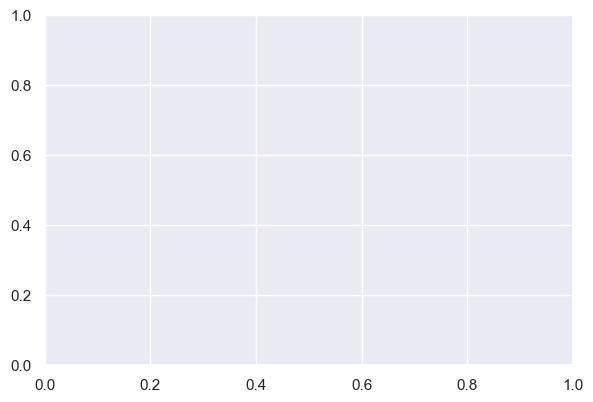

In [124]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.regplot(data=df2_train, x='chuva', y=target, color='#3f72af', scatter_kws={'alpha':0.2})
plt.title('Gráfico com valores zerados')

plt.subplot(2,2,2)
_ = df2_train[df2_train['chuva']>0]
sns.regplot(data=_, x='chuva', y=target, color='#3f72af', scatter_kws={'alpha':0.2})
plt.title('Gráfico sem os valores zerados')

plt.subplot(2,2,3)
sns.heatmap(df2_train[['aluguéis','chuva']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})

plt.subplot(2,2,4)
_ = df2_train[df2_train['chuva']>0][['aluguéis','chuva']].corr()
sns.heatmap(_, annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})

plt.suptitle('\n Análise da variável chuva', fontsize=20)
fig.tight_layout(pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Ao remover os da variável chuva, temos um aumento na correção negativamente, agora que sabemos que o zero na variável tem um impacto na variável de mais informações, vamos dar uma olhada nas estações e temperatura. 
    
</div>

In [ ]:
filtro = (df2_train['chuva']==0) 

_ = df2_train[filtro].groupby('estação').agg({'chuva'       : np.mean, 
                                          'temperatura' : np.mean,
                                          'sol'         : np.mean, 
                                          'umidade'     : np.mean, 
                                          'estação'     : 'count'})

display(_)

filtro = (df2_train['chuva']>0) 
_ = df2_train[filtro].groupby('estação').agg({'chuva'       : np.mean, 
                                          'temperatura' : np.mean,
                                          'sol'         : np.mean, 
                                          'umidade'     : np.mean, 
                                          'estação'     : 'count'})

display(_)

del _

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Na primeira tabela observamos que temos em média 1050 valores com zero nas estações do ano, na segunda tabela temos as estações do ano com a sua média na variável chuva, um pergunta que eu me fiz: Imputando um valor como a média, max ou outro valor estatatísco na variável chuva tem aumento na correlação? <p> <br>
    
    
Vamos fazer esse teste em apenas no verão.
    
</div>

In [ ]:
df_aux   = df2_train.copy()
filtro_1 = (df_aux['chuva']==0) & ((df_aux['estação']=='verão')) 
filtro_2 = (df_aux['chuva']>0) & ((df_aux['estação']=='verão')) 

df_aux_min    = df_aux.copy() 
df_aux_max    = df_aux.copy() 
df_aux_mean   = df_aux.copy() 
df_aux_median = df_aux.copy()

df_aux_min['chuva'][filtro_1]    = df_aux[filtro_2]['chuva'].min()
df_aux_max['chuva'][filtro_1]    = df_aux[filtro_2]['chuva'].max()
df_aux_mean['chuva'][filtro_1]   = df_aux[filtro_2]['chuva'].mean()
df_aux_median['chuva'][filtro_1] = df_aux[filtro_2]['chuva'].median()

plt.figure(figsize=(20,4))

plt.subplot(1,4,1)
sns.heatmap(df_aux_min[['aluguéis','chuva']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Min')

plt.subplot(1,4,2)
sns.heatmap(df_aux_max[['aluguéis','chuva']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Max')

plt.subplot(1,4,3)
sns.heatmap(df_aux_mean[['aluguéis','chuva']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Média')

plt.subplot(1,4,4)
sns.heatmap(df_aux_median[['aluguéis','chuva']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Mediana');

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Acima podemos observar, que ao alterarmos o valor zero na variável chuva quando a estação é verão, passamos a ter uma correlação positiva, saímos de de -0.17 para 0.32, com alteração confirmamos foi imputado na variável chuva.       
    
</div>

- <p style="color: black; font-family: Arial Black"> Variável Sol

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.regplot(data=df2_train, x='sol', y=target, color='#3f72af', scatter_kws={'alpha':0.2})
plt.title('Gráfico com valores zerados')

plt.subplot(2,2,2)
_ = df2_train[df2_train['sol']>0]
sns.regplot(data=_, x='sol', y=target, color='#3f72af', scatter_kws={'alpha':0.2})
plt.title('Gráfico sem os valores zerados')

plt.subplot(2,2,3)
sns.heatmap(df2_train[['aluguéis','sol']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})

plt.subplot(2,2,4)
_ = df2_train[df2_train['sol']>0][['aluguéis','sol']].corr()
sns.heatmap(_, annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})

plt.suptitle('\n Análise da variável sol', fontsize=20)
fig.tight_layout(pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Observamos nos gráficos acima, que a remoção do valor zero da variável **sol** tem efeito na correlação, vamos fazer o mesmo teste que fizemos na variável chuva, a imputação de valor estatístico.  
    
</div>

In [ ]:
df_aux   = df2_train.copy()
filtro_1 = (df_aux['sol']==0) & ((df_aux['estação']=='verão')) 
filtro_2 = (df_aux['sol']>0) & ((df_aux['estação']=='verão')) 

df_aux_min    = df_aux.copy() 
df_aux_max    = df_aux.copy() 
df_aux_mean   = df_aux.copy() 
df_aux_median = df_aux.copy()

df_aux_min['sol'][filtro_1]    = df_aux[filtro_2]['sol'].min()
df_aux_max['sol'][filtro_1]    = df_aux[filtro_2]['sol'].max()
df_aux_mean['sol'][filtro_1]   = df_aux[filtro_2]['sol'].mean()
df_aux_median['sol'][filtro_1] = df_aux[filtro_2]['sol'].median()

plt.figure(figsize=(20,4))

plt.subplot(1,4,1)
sns.heatmap(df_aux_min[['aluguéis','sol']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Min')

plt.subplot(1,4,2)
sns.heatmap(df_aux_max[['aluguéis','sol']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Max')

plt.subplot(1,4,3)
sns.heatmap(df_aux_mean[['aluguéis','sol']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Média')

plt.subplot(1,4,4)
sns.heatmap(df_aux_median[['aluguéis','sol']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Mediana');

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

A imputação da média ou mediana aumenta a correlação da variável com o alvo de 0.26 para 0.28.

</div>

- Variável Visibilidade

In [ ]:
df2_train[df2_train['visibilidade']>=.97]['visibilidade'].describe() 

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.regplot(data=df2_train, x='visibilidade', y=target, color='#3f72af', scatter_kws={'alpha':0.2})
plt.title('Gráfico com valores zerados')

plt.subplot(2,2,2)
_ = df2_train[df2_train['visibilidade']<.97]
sns.regplot(data=_, x='visibilidade', y=target, color='#3f72af', scatter_kws={'alpha':0.2})
plt.title('Gráfico sem os valores zerados')

plt.subplot(2,2,3)
sns.heatmap(df2_train[['aluguéis','visibilidade']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})

plt.subplot(2,2,4)
_ = df2_train[df2_train['visibilidade']<.97][['aluguéis','sol']].corr()
sns.heatmap(_, annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})

plt.suptitle('\n Análise da variável visibilidade', fontsize=20)
fig.tight_layout(pad=3.0)  

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Observamos nos gráficos acima, que a remoção do maior valor da variável <b>visibilidade</b> tem efeito na correlação, vamos fazer o mesmo teste que fizemos na variável chuva, a imputação de valor estatístico.  
    
</div>

In [ ]:
df_aux   = df2_train.copy()
filtro_1 = (df_aux['visibilidade']==0) & ((df_aux['estação']=='verão')) 
filtro_2 = (df_aux['visibilidade']>0) & ((df_aux['estação']=='verão')) 

df_aux_min    = df_aux.copy() 
df_aux_max    = df_aux.copy() 
df_aux_mean   = df_aux.copy() 
df_aux_median = df_aux.copy()

df_aux_min['visibilidade'][filtro_1]    = df_aux[filtro_2]['visibilidade'].min()
df_aux_max['visibilidade'][filtro_1]    = df_aux[filtro_2]['visibilidade'].max()
df_aux_mean['visibilidade'][filtro_1]   = df_aux[filtro_2]['visibilidade'].mean()
df_aux_median['visibilidade'][filtro_1] = df_aux[filtro_2]['visibilidade'].median()

plt.figure(figsize=(20,4))

plt.subplot(1,4,1)
sns.heatmap(df_aux_min[['aluguéis','visibilidade']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Min')

plt.subplot(1,4,2)
sns.heatmap(df_aux_max[['aluguéis','visibilidade']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Max')

plt.subplot(1,4,3)
sns.heatmap(df_aux_mean[['aluguéis','visibilidade']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Média')

plt.subplot(1,4,4)
sns.heatmap(df_aux_median[['aluguéis','visibilidade']].corr(), annot=True, cmap="RdBu", 
            annot_kws={"weight": "bold", "fontsize":13})
plt.title('Mediana');

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não tivemos melhoria com imputação de valores estatístico, outros testes serão feitos no processo de modelagem, pois na remoção obtivemos uma melhoria.  

Vamos plotar um gráfico com todas interações entre as variáveis, para tentarmar identificar algum padrão entre elas. 
    
</div>

In [ ]:
pd.plotting.scatter_matrix(df2_train, alpha=0.3, figsize=(20,15), diagonal='kde');

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
- As variáveis sol e hora tem forma diferente dos outros pares de variáveis, a combinação dessas variáveis podem ajudar a identificar algum padrão, no processo de feature engineering vamos fazer alguns combinações com essas variáveis. 

- Além das correlações lineares que foram abordadas anteriormente, não identifico outros padrões. 


</div>

### 2.8.4. Outliers

In [ ]:
plt.figure(figsize=(12, 10))
f_flot = feature_float.copy() 
f_flot.append(target)

row = int(len(f_flot)/2)+1

for i, col in enumerate(f_flot):   
    plt.subplot(row, 2, i+1)
    sns.boxplot(y=col, data=df2_train);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Temos quatro variáveis com outliers na parte superior (acima da mediana), entre elas a variável <b>alvo</b>, o tratamento dos outliers pode resulta na melhoria do apredizado dos modelos, sendo assim, devemos fazer uma análise e utilizar algumas tecnicas de tratamento de outliers como: 
- Intervalo interquartil; 
- Z-score;
- Envelope Elíptico;
- Isolation Forest.   <p>
    
Vamos dar uma olhada nos outliers com as variáveis qualitativas. 
    
    
</div>

In [ ]:
plt.figure(figsize=(15, 20))
f_flot = feature_float.copy() 
f_flot.append(target)

row = int(len(f_flot)/2)+1

for col_x in feature_cat:           
    plt.figure(figsize=(20, 20))           
    for i, col in enumerate(f_flot):   
        plt.subplot(row, 2, i+1)
        sns.boxplot(y=col, x=col_x, data=df2_train)
        plt.xlabel('')

    plt.suptitle('Variável {}'.format(col_x), fontsize=20); 
    #fig.tight_layout(pad=1.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Um ponto importante que podemos destacar em relação as variáveis: <b>chuva, sol e vento</b>, que os outliers dessas variáveis podem ser resolvidos com os testes que forão realizaod no processo anterior, isto é, com a imputação de valores estatatíscos ou a utilização de um algoritmos, em relação a variável <b>alvo</b> precisamos fazer alguns testes de normalização e tratamento dos outliers.  
    
</div>

## 2.9. Variáveis Alvo 


### 2.9.1. Teste de Normalidade
Para o teste de normalidade vamos utilizar o **Kolmogorov-Smirnov** da biblioteca do sklearn.

In [ ]:
test_ks   = stats.kstest(df2_train[target], 'norm')
statistic = test_ks[0]
pvalue    = test_ks[1]

print('Estatística: {:2.8f}'.format(statistic))
print('P-value    : {:2.8f}'.format(pvalue))
print()

msg = 'Com nível de significância de 0.05 e confiança \nde 95%, os dados {} normalmente distribuidos.'
txt = 'são'
if pvalue<0.05: 
    txt = 'não são'
    
print(msg.format(txt))

### 2.9.2. Transformações 

In [ ]:
power  = PowerTransformer(method='box-cox') # 
y_ori  = df1_train[target] 
y_log  = np.log1p(y_ori)
y_sqr  = np.sqrt(y_ori)
y_bcox = pd.DataFrame(power.fit_transform(pd.DataFrame(y_ori)), columns=['y'])['y']
label  = ['Sem transformação','Log','Raiz quandrada', 'Box-Cox']

list_feature_trans = [y_ori, y_log, y_sqr, y_bcox]

plt.figure(figsize=(20,12))

msg = 'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'

for i, v in enumerate(list_feature_trans):
    plt.subplot(3,4,i+1)
    (mu, sigma) = norm.fit(v)        
    sns.distplot(v, kde=True, hist=True, fit=norm)
    plt.legend([msg.format(mu, sigma)],loc='best')
    plt.xlabel('')
    plt.title('{}'.format(label[i]), fontsize=16)
    
    plt.subplot(3,4,i+5)
    sns.boxplot(y=v)
    
    plt.subplot(3,4,i+9)
    res = stats.probplot(v, plot=plt)
    plt.xlabel('')
    plt.title('')

plt.suptitle('Transformação da variável alvo ({})'.format(target), fontsize=20)
fig.tight_layout(pad=1.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Acima fizemos três transformações na variável alvo: log, raiz quadrada e box-cox, a primeira coluna é a variável sem tranformação, que tem uma distribuição assimétrica positiva com muitos outliers, no gráfico de probabilidade observamos que os valores não se comportam muito bem, indicado a não normalidade dos dados, em relação as transformações temos:   
    
- A transformação de log faz com que os dados tem uma distribuição assimétrica a esqueda e não consegue lidar muito bem com os outliers; <p>
    
- A transformação de raiz quadrada melhara o gráfico de distribuição, consegue lidar com os outliers como podemos observar no gráfico de boxplot com uma médiana comportada, mas não perfeito do gráfico de probalidade; <p>
    
- A transformação de box-cox tem uma distribuição boa no gráfico de distribuição, lida muito bem com os outliers, uma observação importante, a médiana dos dados fica em torno do zero.
    
Vamos fazer o teste de normalidade nas transformações da raiz quadrada e box-cox.    
</div>

In [ ]:
test_ks   = stats.kstest(y_sqr, 'norm')
statistic = test_ks[0]
pvalue    = test_ks[1]

print('Estatística: {:2.8f}'.format(statistic))
print('P-value    : {:2.8f}'.format(pvalue))
print()

msg = 'Com nível de significância de 0.05 e confiança \nde 95%, os dados {} normalmente distribuidos.'
txt = 'são'

if pvalue<0.05: 
    txt = 'não são'
    
print(msg.format(txt))


In [ ]:
test_ks   = stats.kstest(y_bcox, 'norm')
statistic = test_ks[0]
pvalue    = test_ks[1]

print('Estatística: {:2.8f}'.format(statistic))
print('P-value    : {:2.8f}'.format(pvalue))
print()

msg = 'Com nível de significância de 0.05 e confiança \nde 95%, os dados {} normalmente distribuidos.'
txt = 'são'

if pvalue<0.05: 
    txt = 'não são'
    
print(msg.format(txt))

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
  
As transformações utilizadas não foram capazes de normalizar os dados, mas vamos utlizar na modelagem a transformação de raiz quadrada, pois acredito que essa transformação pode ter efeito na modelage e podemos fazer outros testes com outras transformações ou cominações de transformações. 
    
</div>

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. Modelagem </h1>    
</div>

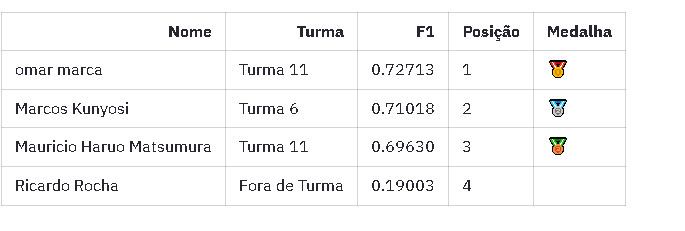

In [ ]:
df3_train = df2_train.copy()
df3_test  = df2_test.copy()

df3_train.shape, df3_test.shape

## 3.1. Processamento 

Neste primeiro momento para linha de base vamos fazer uma binalização das variáveis qualitativas. 

In [ ]:
df3_train[feature_cat].head()

In [ ]:
def feature_binarizer(df_tr_, df_vl_, df_ts_, features_ohe_=None, feature_ord_=None):

    if features_ohe_ is not None:
        for col in features_ohe_:         
            lb   = OneHotEncoder(sparse=False) # LabelBinarizer() OneHotEncoder
            cols = df_tr_[col].unique().tolist() 

            cols_fe = []
            for x in df_tr_[col].unique().tolist(): 
                cols_fe.append('fe_'+ col + '_' +str(x) )

            df_lb_tr = pd.DataFrame(lb.fit_transform (df_tr_[[col]]), columns=cols_fe)
            df_lb_vl = pd.DataFrame(lb.transform (df_vl_[[col]]), columns=cols_fe)
            df_lb_ts = pd.DataFrame(lb.transform (df_ts_[[col]]), columns=cols_fe)
            
            df_lb_tr[cols_fe]= df_lb_tr[cols_fe].astype(int)
            df_lb_vl[cols_fe]= df_lb_vl[cols_fe].astype(int)
            df_lb_ts[cols_fe]= df_lb_ts[cols_fe].astype(int)

            df_lb_tr.index =  df_tr_.index
            df_lb_vl.index =  df_vl_.index
            df_lb_ts.index =  df_ts_.index

            df_tr_ = pd.concat([df_tr_, df_lb_tr], axis=1)
            df_vl_ = pd.concat([df_vl_, df_lb_vl], axis=1)
            df_ts_ = pd.concat([df_ts_, df_lb_ts], axis=1)

            df_tr_.drop(col, axis=1, inplace=True)
            df_vl_.drop(col, axis=1, inplace=True)
            df_ts_.drop(col, axis=1, inplace=True)

    col     = ''
    cols_fe = ''

    if feature_ord_ is not None:
        for col in feature_ord_:
            ordEncoder = OrdinalEncoder()            
            cols = df_tr_[col].unique().tolist() 

            cols_fe = []
            for x in df_tr_[col].unique().tolist(): 
                cols_fe.append('fe_'+ col + '_' +str(x) )
                
            df_tr_[col] = ordEncoder.fit_transform(df_tr_[[col]])
            df_vl_[col] = ordEncoder.transform (df_vl_[[col]])
            df_ts_[col] = ordEncoder.transform (df_ts_[[col]])

    return df_tr_, df_vl_, df_ts_

## 3.1. Split Train/Test

In [ ]:
df3_train = Ultil.reduce_memory_usage(df3_train)
df3_test  = Ultil.reduce_memory_usage(df3_test)

In [ ]:
X      = df3_train.drop(target, axis=1)
y      = df3_train[target].values
X_test = df3_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      random_state = 12359)

cols_oho = ['estação', 'feriado',] 
cols_ord = ['dia']

X_train, X_valid, X_test = feature_binarizer(X_train.copy(), X_valid.copy(), X_test.copy(), cols_oho, cols_ord)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

In [ ]:
X_train.head()

## 3.2. Treinamento

In [ ]:
def delete_files(namefile):
                
        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))

In [ ]:
cols = X_valid.columns.to_list()
cols_model_1 = cols
print(cols)

In [ ]:
%%time 
seed   = 12359
params = {'objective'        : 'reg:squarederror', 
          'eval_metric'      : 'rmse', 
          'n_estimators'     : 2000,         
          'max_depth'        : 7, 
          'learning_rate'    : .01, 
          'subsample'        : 0.7, 
          'colsample_bytree' : 0.8, 
          'reg_alpha'        : 0.9,    #           
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

scalers = [None, 
           StandardScaler(),
           RobustScaler(), 
           MinMaxScaler()                     
          ]

scaler_best    = None
model_best     = None
score_best     = np.mean(y)
cols           = ['hora','dia','temperatura','chuva', 'umidade', 'sol', 'visibilidade','vento']


for i , scaler in enumerate(scalers): 
    
    model_baseline = xgb.XGBRegressor(**params)
    n_estimators   = int(model_baseline.get_params()['n_estimators']*.1)
    
    X_train_s = X_train.copy() 
    X_valid_s = X_valid.copy()
    X_test_s  = X_test.copy()
    
    if scaler!=None:                      
        X_train_s[cols] = scaler.fit_transform(X_train_s[cols])
        X_valid_s[cols] = scaler.transform(X_valid_s[cols])
        X_test_s[cols]  = scaler.transform(X_test[cols])
    
    y_train_nor = y_train
    y_valid_nor = y_valid
    eval_set    = [(X_train, y_train), (X_valid, y_valid)]
    
    model_baseline.fit(X_train_s, 
                       y_train_nor, 
                       eval_set  = eval_set,                                               
                       verbose   = False, 
                       early_stopping_rounds = n_estimators)

    score_tr  = model_baseline.score(X_train_s, y_train_nor)  
    y_pred_vl = model_baseline.predict(X_valid_s, ntree_limit=model_baseline.best_ntree_limit)
    y_pred_ts = model_baseline.predict(X_test_s,  ntree_limit=model_baseline.best_ntree_limit)
    
    y_pred_vl = np.int64(y_pred_vl)

    rmse, mae, mse, mape, r_squared = Ultil.evaluation(y_valid, y_pred_vl)    
    
    msg = 'RMSE: {:2.2f} - MAE: {:2.2f} - MSE: {:2.2f} - MAPE: {:2.2f} - R2: {:2.2f} - RMSE Trn: {:2.8f} => {}'     
    print(msg.format(rmse, mae, mse, mape, r_squared, score_tr,  scaler))
    
    if (rmse)<score_best:        
        score_best   = (rmse)
        scaler_best  = scaler    
        y_valid_best = y_pred_vl
        X_train_best = X_train_s.copy()
        X_valid_best = X_valid_s.copy()
        model_best   = model_baseline
                
    # Gera arquivo de submissão    
    delete_files('xgb_01_base_line_score')
    
    name_file_sub         = 'xgb_01_base_line_score_{:2.2f}_{}.csv'.format(rmse, str(scaler).lower()[:4])
    df_submission[target] = np.int64(y_pred_ts)    
    df_submission.to_csv(path + 'Data/submission/' + name_file_sub, index=False)
    
df_pred = pd.DataFrame({'y': y_valid, 'y_pred': y_valid_best })
df_pred['residuals'] = df_pred['y'] - df_pred['y_pred']

print()
print('The Best')  
print('Scaler: {}'.format(scaler_best))    
print('Score : {:2.2f}'.format(score_best))
print()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
- Podemos destacar um ponto importante no resultado acima, <b>RMSE</b> é 42% acima do <b>MAE</b>, isso é um indicativo que os outliers estão afetando as previsões, pois a métrica (RMSE) é penalizada com os maiores erro da nossa previsão, sendo assim, temos um trabalho a fazer em relação aos outliers, que mencionamos nas análises e os tipos de tratamentos que podemos fazer.  <p>
    
- Abaixo a submissão das previssões na competição com RMSE de 247.78 que representa um aumento de 0.02%, a minha maior preocupação é ter um modelo robusto, pois estamos sendo avaliado em 30% dos dados de teste, que torna a competição emocionante, pois as colocações podem muda no final.     
      
</div>

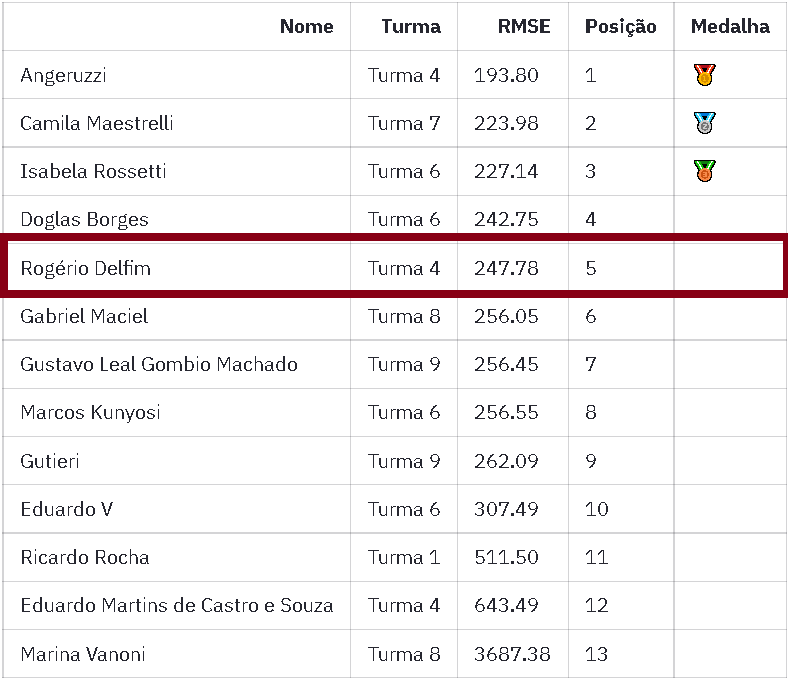

## 3.3. Anállise
Vamos começa plotando os valores real x preditos. 

### 3.3.1. Real x Predito

In [ ]:
results = model_baseline.evals_result()

result_tr = results["validation_0"]['rmse']
result_vl = results["validation_1"]['rmse']
ntree_limit = model_baseline.best_ntree_limit

In [ ]:
sample = 250
x_ax   = range(len(y_valid[:sample]))

y_nor  = df_pred.loc[:sample-1].y
y_pred = df_pred.loc[:sample-1].y_pred

plt.figure(figsize=(15,15))

plt.subplot(6,1,1)
plt.scatter(x_ax, y_nor, s=5, color="blue", label="Real") 
plt.scatter(x_ax, y_pred, s=5, color="red" , label="Predito")
plt.title("\n Previsão em dados de validação \n",  fontsize=20)

plt.subplot(6,1,2)
plt.scatter(x_ax, y_nor, s=5, color="blue", label="Real")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="Predito")
plt.legend()

plt.subplot(6,1,3)
plt.plot(x_ax, y_nor,  label="Real")
plt.plot(x_ax, y_pred, label="Predito")
plt.legend()

plt.subplot(6,1,4)
plt.plot(result_tr, label="Treinamento")
plt.plot(result_vl, label="Validação")
plt.axvline(ntree_limit, color="gray", label="N. de árvore ideal {}".format(ntree_limit))
plt.legend()

plt.subplot(6,1,5)
plt.hist(df_pred['y'], bins=30, label='Real')
plt.legend()

plt.subplot(6,1,6)
plt.hist(df_pred['y_pred'], bins=30, label='Previsto') 
plt.legend()

plt.tight_layout(pad=2.0);

In [ ]:
df_pred[df_pred['y_pred']<=0]

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
- Observamos nos três primeiros gráficos, que o modelo tem dificuldade nas previsões acima de 1200, isso  pode ser um  sinal que os outliers estão influenciando nas previsões, é ponto que devemos ter atenção no processamento dos dados; <p> 
    
- No quarto gráfico, observamos o overfitting apartir do ponto 400 (número de estimadores), precisamos fazer ajustes no parametros, principal no número de estimadores; <p> 
    
- No quinto e sexto gráficos, observamos que a distribuição dos dados de previsão seguem a mesma distribuição dos dados de treino, isso é bom, porém o modelo gerou previsões negativas como podemos observar no quinto gráfico e na tabela listada acima, não deveria acontecer isso, pois não temos valores negativos no dados de treino, provavelmente isso é efeito do overfitting, principalmento com o parametros de número de estimadores (<b>n_estimators</b>).
    
</div>

### 3.3.2. Resíduo

In [ ]:
plt.figure(figsize=(12,7))
visualizer = ResidualsPlot(model_best, hist=True,)
visualizer.fit(X_train_best, y_train_nor)  
visualizer.score(X_valid_best, y_valid_nor)
visualizer.show();

r2_dif_tr_x_tr = (1-visualizer.test_score_ /visualizer.train_score_)*100
print('Diferença R2 treino x teste: {:2.2f}%'.format(r2_dif_tr_x_tr))

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Obsevamos que temos alguma aleatóriedade nos resíduos, isso parece indicar que o modelo é bom, também podemos ver pelo histograma que nossos erros são quase normalmente distribuído em torno de zero, porém precisamos fazer ajustes no modelo para ganhar robustez, outro ponto importante é <b>R2 (R-quadrado)</b> do treinamento em relação ao teste que é 13% acima indicando um overfiting, o qual podemos trabalhar em melhoria nos dados e parametros dos modelos. <p> <br>
    
    
<b>OBSERVAÇÃO</b>: <p>
O <b>R-quadrado</b> é uma medida estatística de quão próximos os dados estão da linha de regressão ajustada. Ele também é conhecido como o coeficiente de determinação ou o coeficiente de determinação múltipla para a regressão múltipla. 
    
</div>

### 3.3.3. SHAP Values
Para uma análise detralhada das previsões vamos utilizar o **SHAP (SHapley Additive exPlanations)**, é uma técnica usada para interpretar os "black-box models" para explicar a saída de qualquer modelo de Machine Learning, com ele podemos ter uma maior explicabilidade dos impactos das variáveis nas predições.  <p>
        
O **SHAP mede o impacto das variáveis, levando em consideração a interação com outras variáveis**, é verificado a importância de uma variável comparando o que um modelo prevê com e sem a variável, isso é feito em todas as ordens possíveis, para que as variáveis sejam comparadas de maneira justa. 

Desenvolvido por [Scott M. Lundberg.](https://scottlundberg.com/)

    

#### 3.3.3.1. Explainer 

In [ ]:
#explainer   = shap.TreeExplainer(model_baseline)
#shap_values = explainer(X_train_best)

explainer   = shap.Explainer(model_baseline)
shap_values = explainer(X_train_best) 

#### 3.3.3.2. Featuere Importance

In [ ]:
shap.plots.bar(shap_values, max_display=50)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
O gráfico de importância das variáveis mostra que as variáveis: <b>umidade, temperatura e sol</b>, são os três principais fatores que impulsionam as previsões do modelo, um destaque maior para <b>umidade</b>. A primeira impressão, parece um resultado que faz sentido, pois nas análises (EDA) que fizemos essas variáveis se mostravam promissoras e se destacam, são três variáveis que podemos trabalhar para melhorar o desempenho dos modelos na <b>Engenharia de Recursos</b>.  <p> <br>       
    
    
Vamos dar uma olhada no comportamento dos grupos de variáveis.     
</div>

In [ ]:
cluster = shap.utils.hclust(X_train_best, y_train, linkage='single') 
shap.plots.bar(shap_values, clustering=cluster, clustering_cutoff=1, merge_cohorts=True)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
     
No gráfico acima temos alguns clustering de variáveis qua aumentam a participação na predição do modelo, isso nos dar uma idéia de como podemos criar novas variáveis que pondem ajudar no desempenho do modelo, podemos descatar as variáveis <b>fe_feriado_não e fe_feriado_sim</b> que foram transformadas <b>one hot conding</b>, elas individualmente tem um valor baixo em relação a junção dessas variáveis. 
</div>

#### 3.3.3.3. Impacto da variável 

In [ ]:
shap.summary_plot(shap_values, X_train_best, max_display=30)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Acima observamos que a **umidade** afeta as previsões negativamente, <b>temperatura, sol e hora</b> são variáveis que tem impacto positivo nas previsões, com um destaque para a variável <b>sol</b> que tem uma pequena parcela da amostra que afeta negativamente as previsões, a descritização dessa variável pode ser uma solução de melhoria.     
    
</div>

#### 3.3.3.4. Gráfico de força coletiva
  
O trecho de código abaixo é demorado, em grandes bases de dados devemos trabalhar com uma amostra. 

In [ ]:
%%time 

shap.initjs()
shap.force_plot(shap_values, shap_values, X_train_best)

Vamos dar uma olhada na variável temperatura. 

In [ ]:
explainer   = shap.TreeExplainer(model_baseline)
shap_values = explainer.shap_values(X_train_best)

col       = 'hora'
inds      = shap.approximate_interactions(col, shap_values, X_train_best)
fig, axes = plt.subplots(5,2,figsize=(20,30))
axes      = axes.ravel()

for i in range(10):    
    shap.dependence_plot(col, shap_values, X_train_best, 
                         interaction_index=inds[i], ax=axes[i], show=False)

## 3.4. Validação Cruzada

<div class="alert alert-block alert-info">

Na validação cruzada neste primeiro momento, vamos treinar o modelo com 80% dos dados e 20% será utilizado para medir a performance do modelo em dados não visto no treinamento, vamos fazer o treinamento de 5 e 10 folds e fazer uma pequena análise. 
    
    
</div>

In [ ]:
X      = df3_train.drop(target, axis=1)
y      = df3_train[target]
X_test = df3_test

cols_oho = ['estação', 'feriado',] 
cols_ord = ['dia']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = X['feriado'],                                               
                                                      random_state = 12359)


X_train, X_valid, X_test = feature_binarizer(X_train.copy(), X_valid.copy(), X_test.copy(), cols_oho, cols_ord)

X, _, X_test = feature_binarizer(X.copy(), X.copy(), df3_test.copy(), cols_oho, cols_ord)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

In [ ]:
def save_data_model(model_, model_name_, path_, df_, y_pred_test_prob_, y_pred_test_subm_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_) + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_) + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(df_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            model_name_ = model_name_.format(score_, seed_)
            df_submission[target] = y_pred_test_subm_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [ ]:
def save_data_model(model_, model_name_, path_, df_, y_pred_test_prob_, y_pred_test_subm_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_) + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_) + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(df_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            model_name_ = model_name_.format(score_, seed_)
            df_submission[target] = y_pred_test_subm_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [ ]:
def df_return_preds_stacking(model_name_=None, path_='', target_='target', level=1): 

    if level==1: 
        level_ = 'n1'
    else: 
        if level==2:
            level_ = 'n2'
        else: 
            level_ = 'n3'

    paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

    if model_name_==None: 
        model_name_=''

    for i, p in enumerate(paths): 

        p = path_ + p 

        name_file_pkl     = glob.glob(p + '/'+ model_name_ + '*.pkl.z')
        dic_preds_mdl_pkl = dict()    

        for p_name in name_file_pkl:    
            y_model_pkl_name_col  = p_name.replace(p + '\\', '').replace('.pkl.z','') 
            #y_model_pkl           = jb.load(p_name)
            df_pkl =jb.load(p_name)

            if i==0: 
                x_proba = df_pkl
            else: 
                x_proba = df_pkl['y_proba']        

            dic_preds_mdl_pkl[y_model_pkl_name_col] = x_proba

        if i==0:
            df_ts = pd.DataFrame(dic_preds_mdl_pkl)
        else: 
            df_tr = pd.DataFrame(dic_preds_mdl_pkl) 
            df_tr[target_] = df_pkl['y_proba']
            
    return df_tr, df_ts 

In [ ]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, lb_, fold_=5, path_='',  
                    seed_=12359, feature_scaler_=None, print_report_=False, save_submission_=False, 
                    save_predict_=False, level_='1', cutoff_value_save_=.6, 
                    train_with_created_folds_=False):
    
    n_estimators    = model_.get_params()['n_estimators']             
    valid_preds     = {}
    taco            = 76 
    acc_best        = 0  
    df_preds        = pd.DataFrame()
    feature_imp     = pd.DataFrame()
    test_preds      = []
    preds           = []
    model           = []
    folds           = []
    cols_sencond_level = ['fold', 'idx_fold', 'y', 'y_pred', 'residuo']
    
    for i, scaler_ in enumerate(scalers_):
        
        # Recuperar os indices do kf 
        if train_with_created_folds_:
            for i in range(fold_):         
                folds.append(jb.load(path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(fold_, i+1)))
        else:
            #folds = KFold(n_splits=fold_, shuffle=False, random_state=seed_)
            folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
            folds = folds.split(X_, y_)

        time_start  = datetime.now()
        score     = [] 
        score_mae = []
                
        if scaler_!=None:            
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
        else:
            string_scaler = None 
            
        y_pred_test = np.zeros(len(X_test_))        
        
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)
        
        y_pred_test_oof = 0      
        second_level    = np.zeros((X_.shape[0], 5))        

        for fold, (trn_idx, val_idx) in enumerate(folds): 

            time_fold_start = datetime.now()
            
            if train_with_created_folds_:
                trn_idx = folds[fold][trn_idx]
                val_idx = folds[fold][val_idx]
            
            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
                      
            # ---------------------------------------------------- 
            # Processamento 
            # ---------------------------------------------------- 
            X_tst = X_test_.copy()
            
            if scaler_!=None: 
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_].values)
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_].values)                       
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_].values) 
                else:                               
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_tst.copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------                 
            y_pred_val       = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)
            y_pred_test_oof += model_.predict(X_tst, ntree_limit=model_.best_ntree_limit) / fold_
                        
            second_level[val_idx, 0] = fold+1 
            second_level[val_idx, 1] = val_idx 
            second_level[val_idx, 2] = y_val.values
            second_level[val_idx, 3] = y_pred_val 
            second_level[val_idx, 4] = np.int64(y_val.values - y_pred_val) 
            
            # ---------------------------------------------------- 
            # Score 
            # ----------------------------------------------------                         
            rmse, mae, mse, mape, r_squared = Ultil.evaluation(y_val, y_pred_val)  
                       
            score.append(rmse)     
            score_mae.append(mae)
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['rmse_'+str(fold+1)] = rmse
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = Ultil.diff(time_fold_start, datetime.now())
            msg = '[Fold {}] RMSE: {:2.2f} - MAE: {:2.2f} - MAPE: {:2.2f}  - {}'
            print(msg.format(fold+1, rmse, mae, mape, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ }
            
            model.append(dic_model)
        
        df_preds           = pd.DataFrame(second_level, columns=cols_sencond_level)
        df_preds['scaler'] = string_scaler
        
        for col in ['fold', 'idx_fold', 'y', 'y_pred']:
            df_preds[col] = df_preds[col].astype(np.int)
        
        score_mean     = np.mean(score) 
        score_std      = np.std(score)
        score_mae_mean = np.mean(score_mae)
        
        if score_mean > acc_best:     
            acc_best    = score_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = Ultil.diff(time_start, datetime.now())   

        msg ='[Mean Fold] RMSE: {:2.2f} std: {:2.2f} - MAE {:2.2f} - {}'
        
        print('-'*taco)        
        print(msg.format(score_mean,score_std, score_mae_mean, time_end))
        print('='*taco)
        print()
                                         
        # Salvar as predições
        if save_submission_:        
            y_pred_test_oof = np.int64(y_pred_test_oof)
            save_data_model(model_             = model_, 
                            model_name_        = model_name_+'_score_{:2.5f}_seed_{}_'+str(scaler_).lower()[:4], 
                            path_              = path_,                             
                            df_                = df_preds,          # stacking
                            y_pred_test_prob_  = y_pred_test_oof,   # stacking 
                            y_pred_test_subm_  = y_pred_test_oof,   # sumission 
                            score_             = score_mean, 
                            seed_              = seed_, 
                            level_             = level_, 
                            target_            = target_, 
                            cutoff_value_      = cutoff_value_save_) 
            
    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.2f}'.format(acc_best))
    print('-'*taco)
    print()
    
    Ultil.free_gpu_cache()
    
    return model, df_preds , feature_imp 

In [ ]:
def create_kfolds(folds, X_, y_):

    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=12359)

    for fold, (trn_idx, val_idx) in enumerate(kf.split(X_, y_, groups=y_)):   
        idx  = {'trn_idx': trn_idx, 'val_idx': val_idx}
        file = path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(folds,fold+1)
        jb.dump(idx, file)
        print('Fold: {}'.format(fold+1))

### 3.4.1 Treinar com 5 Folds

In [ ]:
create_kfolds(5, X, y)

In [ ]:
%%time 

seed        = 12359
eval_metric = ['rmse']                 
scalers     = [StandardScaler()]               

seed   = 12359
params = {'objective'        : 'reg:squarederror', 
          'eval_metric'      : 'rmse', 
          'n_estimators'     : 2000,         
          'max_depth'        : 7, 
          'learning_rate'    : .01, 
          'subsample'        : 0.7, 
          'colsample_bytree' : 0.8, 
          'reg_alpha'        : 0.9,           
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model_name = 'xgb_02_cv_05_folds'

delete_files(model_name)

model_kf5, df_preds_kf5, feature_imp_kf5 = \
    cross_val_model(model_           = xgb.XGBRegressor(**params),
                    model_name_      = model_name,
                    X_               = X_train,
                    y_               = y_train,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 5,
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None,                     
                    save_submission_ = True, 
                    #train_with_created_folds_ = True
                   )

print()

### 3.4.1 Treinar com 10 Folds

In [ ]:
%%time 

seed        = 12359
eval_metric = ['rmse']                 
scalers     = [StandardScaler()]               

seed   = 12359
params = {'objective'        : 'reg:squarederror', 
          'eval_metric'      : eval_metric, 
          'n_estimators'     : 2000,         
          'max_depth'        : 7, 
          'learning_rate'    : .01, 
          'subsample'        : 0.7, 
          'colsample_bytree' : 0.8, 
          'reg_alpha'        : 0.9,
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model_name = 'xgb_03_cv_10_folds'

delete_files(model_name)

model_kf10, df_preds_kf10, feature_imp_kf10 = \
    cross_val_model(model_           = xgb.XGBRegressor(**params),
                    model_name_      = model_name,
                    X_               = X_train,
                    y_               = y_train,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 10,
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None,                     
                    save_submission_ = True)

print()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
     
Podemos observar com aumento de dobras (kfolds) para o treinamento do modelo obtivemos um redução no <b>RMSE</b> e uma pequena redução no **MAE**, porém a variância duplicou , sendo assim, acredito que a melhoria no <b>RMSE</b> é muito pequena em relação a variância, e vamos fazer as próximas análise em cima do 5 folds.    
    
</div>

## 3.5. Análise do Modelo 

### 3.5.1. Feature Importances  

In [ ]:
plt.figure(figsize=(15,12))

cols  = feature_imp_kf5.filter(regex=r'fold').columns.to_list()
folds = len(cols)
row   = int(folds/2+1)

for fold, col in enumerate(cols):            
    col_acc = 'rmse_' + str(fold+1)
    df_fi = feature_imp_kf5.sort_values(by=col, ascending=False).reset_index().iloc[:15]
    df_fi = df_fi[['index', col, col_acc]]
    df_fi.columns = ['Feature', 'score', col_acc]
    plt.subplot(row, 2, fold+1)
    sns.barplot(x='score', y='Feature', data=df_fi)    
    plt.title('Fold {} - score: {:2.2f}'.format(fold+1, df_fi[col_acc].mean()), 
              fontdict={'fontsize':18})    

plt.suptitle('Feature Importance XGB - {} folds'.format(folds) , y=1.01, fontsize=24);
plt.tight_layout(h_pad=3.0); 

### 3.1.1. Erro e  número de Estimadores

In [ ]:
cols  = feature_imp_kf5.filter(regex=r'fold').columns.to_list()
folds = len(cols)
row   = int(folds/2+1)

for erro in eval_metric:
    plt.figure(figsize=(15,12))

    for i in range(len(model_kf5)):
        results     = model_kf5[i]['model'].evals_result() # merror
        ntree_limit = model_kf5[i]['model'].best_ntree_limit

        plt.subplot(row,2,i+1)
        plt.plot(results["validation_0"][erro], label="Treinamento")
        plt.plot(results["validation_1"][erro], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))

       # plt.xlabel('Número de árvores')
        plt.ylabel(erro)
        plt.legend();

    plt.suptitle('Performance XGB - {}'.format(erro), y=1.01, fontsize=24);
    plt.tight_layout(h_pad=3.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Podemos observar acima o overfitting no treinamento do modelo, isso fica claro com a <b>validação cruzada</b> que é robusta em relação a <b>validação  Holdout </b>, que teve melhor resultado tanto na submissão quanto no treino, porém estamos sendo avaliados em 30% dos dados de teste, para resolver esse problema precisamos ajustar os parametros do modelo.
        
</div>

### 3.1.2. Previsão 

Vamos fazer a previsão em dados não vistos no treinamento. 
    

In [ ]:
num_model  = 1
scaler_tr  = model_kf5[num_model]['scaler']
model_tr   = model_kf5[num_model]['model']
X_valid_sc = pd.DataFrame(scaler_tr.transform(X_valid), columns=X_valid.columns)

y_pred_val = model_tr.predict(X_valid_sc, ntree_limit=model_tr.best_ntree_limit)

rmse, mae, mse, mape, r_squared = Ultil.evaluation(y_valid, y_pred_val)

print('RMSE: {:2.2f} - MAE: {:2.2f} - MAPE: {:2.2f}'.format(rmse, mae, mape))

In [ ]:
explainer   = shap.Explainer(model_tr)
shap_values = explainer(X_valid_sc) 
shap.plots.bar(shap_values, max_display=50)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
A previsão em dados não visto no treinamento temos uma previsão de 7% acima do **RMSE** de treinamento, de certa forma o modelo generalizar em dados não visto, mas temos uma oportunidade de melhoria na modelagem.   
    
    
</div>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. Conclusão </h1>    
</div>

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Neste notebook fizemos uma análise para conhencer os dados da competição e identificamos diversos insights, os quais foram descritos no decorrer das análise, podemos destacar alguns: 
    
- Temos um aumento do aluguél de bicicleta no período das 10h até as 18, 8h temos um pico representativo;
- No verão temos o maior número de aluguéis, caindo no inverto significativamente principalmente quando temos chuva. <p> <br>        
    
No treimanto dos modelos, o melhor resultado foi obtido com na validação cruzadas com 10 k folds, porém vamos utilizar 5 folds nos próximos notebook, pois a variância nos 10 folds é o doblo.  <br>
    
Os próximos passos são: <br> 
- Testar novos classificadores; <br>
- Tunning;<br>
- Feature selection. <br><p>    
    
<p style="color: black; font-family: Arial Black">REFERÊNCIAS: </p>
    
- https://www.kaggle.com/code/cabaxiom/tps-may-22-visualising-feature-interaction <br>
- https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model <br>
- https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras/notebook <br>   
- https://www.bixtecnologia.com.br/como-eu-gostaria-que-alguem-me-explicasse-shap-values/ <br>
- https://www.scikit-yb.org/en/latest/api/regressor/index.html <br>
    
</div>